In [1]:
import yaml
import sys
sys.path.append("../")
from plugins.interfaces.diagnostics import AWAFrameGrabberDiagnostic, ROI

# define screen and trim parameters
screen = "DYG5"
magnet_info = yaml.safe_load(open("awa_config/awa_drive_magnet_config.yml"))
screen_info = yaml.safe_load(open("awa_config/awa_drive_camera_config.yml"))[screen]

In [2]:
# create Xopt objects
from xopt import VOCS
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            #"log10_total_intensity": ["GREATER_THAN", 5.55]
        }

vocs = VOCS(
    variables = {
        "AWA:Bira3Ctrl:Ch05":[-2.0,2.0], # DQ6
        "AWA:Drive:DS3:Ctrl": [130.0,250.0], # Matching solenoid
        "AWA:Drive:DS1:Ctrl": [450.0,550.0], # Bucking solenoid
    },
    constraints = IMAGE_CONSTRAINTS,
    observables = ["Sx_squared", "Sy_squared"],
)

In [3]:
vocs.variable_names

['AWA:Bira3Ctrl:Ch05', 'AWA:Drive:DS1:Ctrl', 'AWA:Drive:DS3:Ctrl']

In [4]:
screen_roi = ROI(
    xcenter=int(screen_info["center"][0]),
    ycenter=int(screen_info["center"][1]),
    xwidth=int(screen_info["radius"]*1.5),
    ywidth=int(screen_info["radius"]*1.5),
)

image_diagnostic = AWAFrameGrabberDiagnostic(
    roi=screen_roi, apply_bounding_box_constraint=True, visualize=False,
    save_image_location="../../awa_data/03_14_BAX/",
)

In [5]:
image_diagnostic

AWAFrameGrabberDiagnostic(screen_name='AWANIFrameGrabber', ip_address='N/A', alias=None, array_data_suffix='N/A', array_n_cols_suffix='N/A', array_n_rows_suffix='N/A', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file=None, save_image_location='../../awa_data/03_14_BAX/', roi=ROI(xcenter=293, ycenter=248, xwidth=310, ywidth=310), gain=1.0, min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=False, verbose=True, return_statistics=False, threshold=0.0, apply_bounding_box_constraint=True, target_charge=None, target_charge_pv=None, charge_atol=0.1, testing=False)

In [6]:
#image_diagnostic.measure_background()

In [7]:
#import matplotlib.pyplot as plt
#plt.imshow(image_diagnostic.background_image)

displaying image
fitting image
{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 76.93762353387592,
 'log10_total_intensity': 6.8181800196616145,
 'total_intensity': 6579305.0}


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 76.93762353387592,
 'total_intensity': 6579305.0,
 'log10_total_intensity': 6.8181800196616145}

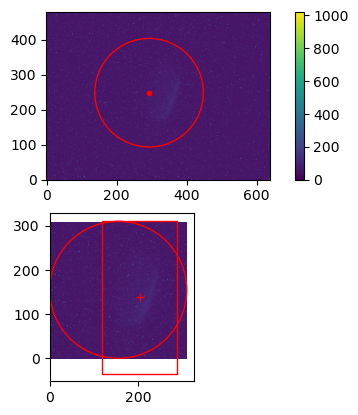

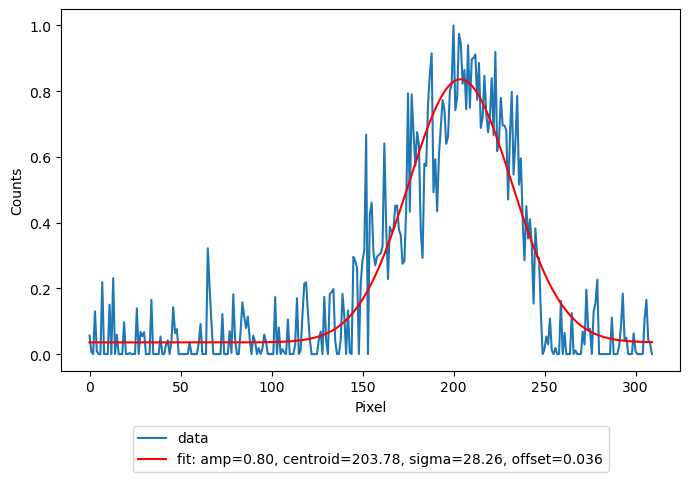

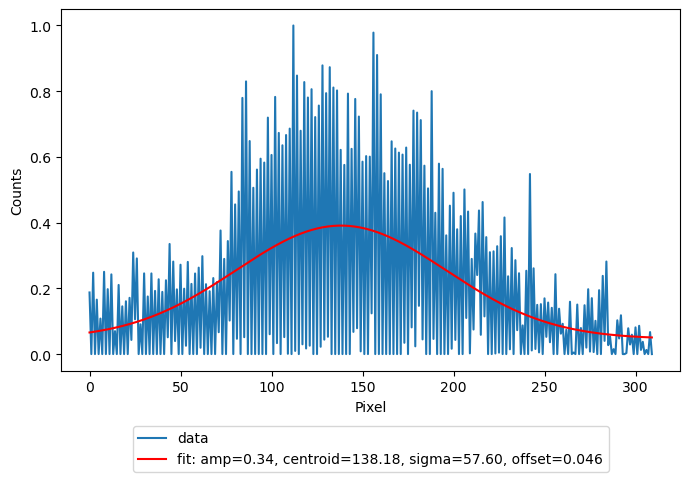

In [8]:
image_diagnostic.test_measurement()

In [9]:
import time
from xopt import Evaluator
from epics import caput

def evaluate(inputs: dict):
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(3.0)

    results = image_diagnostic.measure_beamsize(1, **inputs)
    results["Sx_m"] = results["Sx"] * 25 / screen_info["radius"]
    results["Sx_squared"] = results["Sx_m"]**2

    results["Sy_m"] = results["Sy"] * 25 / screen_info["radius"]
    results["Sy_squared"] = results["Sy_m"]**2
    
    # measure distance to image center
    print(results["Cx"], image_diagnostic.roi.xwidth/2)
    results["center_dist_x"] = results["Cx"] - image_diagnostic.roi.xwidth/2
    results["center_dist_y"] = results["Cy"] - image_diagnostic.roi.ywidth/2

    results["center_dist"] = (results["center_dist_x"]**2 + results["center_dist_y"]**2)**0.5
    results["time"] = time.time()
    
    return results

evaluator = Evaluator(function=evaluate)

In [10]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.super_low_noise import SuperLowNoiseModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from xopt.numerical_optimizer import GridOptimizer
from copy import deepcopy
sys.path.append("../../emitopt/")
import torch
from emitopt.algorithms import ScipyMinimizeEmittanceXY

meas_dim = 0
tuning_dims = [1,2]
covar_module = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Sx_squared': scaled_covar_module, "Sy_squared": deepcopy(scaled_covar_module)}
# covar_module_dict = {}
model_constructor = SuperLowNoiseModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

from emitopt.utils import get_quad_scale_factor
q_len=0.1

pv_scale = (q_len*10 / 0.893) # [kG] / [A] for AWA Blue quads
geo_scale_factor = get_quad_scale_factor(E=0.060, q_len=q_len) # [m^-2] / [kG] 


scale_factor = pv_scale * geo_scale_factor
rmat_x = torch.tensor(((1.0,2.375),(0.0,1.0)))
rmat_y = torch.tensor(((1.0,2.375),(0.0,1.0)))
n_samples=10

algo_kwargs = {
        'x_key': 'Sx_squared',
        'y_key': 'Sy_squared',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': False,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    numerical_optimizer=GridOptimizer(n_grid_points=10)
    #n_interpolate_points=5,
)

generator = BayesianExplorationGenerator(
    vocs=vocs,
    gp_constructor=model_constructor, 
    numerical_optimizer=GridOptimizer(n_grid_points=10)
)



CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:52842, Ignored: 192.168.0.2:52842"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Mar 18 2024 14:08:31.956191554
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "AWANIFG:ImgData", Connecting to: 192.168.2.57:52842, Ignored: awa3.hep.anl.gov:52842"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Mar 18 2024 14:08:31.957143343
..................................................................


In [11]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, 
         evaluator=evaluator, strict=True)#,dump_file="bax_emittance_3d_x_y_2.yml")

In [12]:
X


            Xopt
________________________________
Version: 2.2.1+8.g7a7eff90.dirty
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    n_grid_points: 10
    name: grid
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints:
    bb_penalty:
    - LESS_THAN
    - 0.0
  objectives: {}
  observables:
  - Sx_squared
  - Sy_squ

In [13]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
import numpy as np
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))
print(current_value)

# create a mesh
n_samples = 5
xx = np.meshgrid(
    np.linspace(-2.0, 0.5, 3),
    np.linspace(150.0, 250.0,3),
    np.linspace(525.0, 550.0,3)
)
pts = np.vstack([ele.flatten() for ele in xx])
print(len(pts))

import yaml
#with open("bax_scan_smaller_range.yml") as stream:
#    d =yaml.safe_load(stream)
#X.add_data(pd.DataFrame(d['data']))


X.evaluate_data({
    "AWA:Bira3Ctrl:Ch05":pts[0],
    "AWA:Drive:DS3:Ctrl":pts[1],
    "AWA:Drive:DS1:Ctrl":pts[2],

});
#import yaml
#X.random_evaluate(2)#, custom_bounds=random_sample_region)

{'AWA:Bira3Ctrl:Ch05': -2.0, 'AWA:Drive:DS1:Ctrl': 525.0, 'AWA:Drive:DS3:Ctrl': 150.0}
3
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
190.1923060937935 155.0
fitting image
191.18784484903782 155.0
fitting image
190.4200231452928 155.0
fitting image
169.8360045113187 155.0
fitting image
173.91691486552418 155.0
fitting image
175.86983640013608 155.0
fitting image
184.47554044563793 155.0
fitting image
180.41946233147934 155.0
fitting image
nan 155.0
fitting image
192.37381442333316 155.0
fitting image
192.553862687404 155.0
fitting image
192.709286829223 155.0
fitting image
199.22794377447013 155.0
fitting image
199.37902343634428 155.0
fitting image
199.89327772901203 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
169.6578216301387 155.0
fitting image
176.7177045921852 155.0
fitting image
172.37267910575218 155.0


In [14]:
for i in range(40):
    X.step()

fitting image
188.40704965122893 155.0
fitting image
197.90207397999987 155.0
fitting image
192.35195142578965 155.0
fitting image
181.754745171716 155.0
fitting image
153.81165536244393 155.0
fitting image
168.2451229058219 155.0
fitting image
187.63819928204578 155.0
fitting image
182.00141458704346 155.0
fitting image
195.38018233506148 155.0
fitting image
194.15325341930034 155.0
fitting image
nan 155.0
fitting image
194.63127171267584 155.0
fitting image
169.65913327027025 155.0
fitting image
nan 155.0
fitting image
nan 155.0
fitting image
181.84249709945215 155.0
fitting image
177.81632851961552 155.0
fitting image
191.55189247501818 155.0
fitting image
156.64151041772445 155.0
fitting image
193.50138350738035 155.0
fitting image
nan 155.0
fitting image
195.68704811815604 155.0
fitting image
191.14988549998472 155.0
fitting image
179.99892451647992 155.0
fitting image
162.7435748940568 155.0
fitting image
171.73581388096858 155.0
fitting image
184.77772647588077 155.0
fitting ima

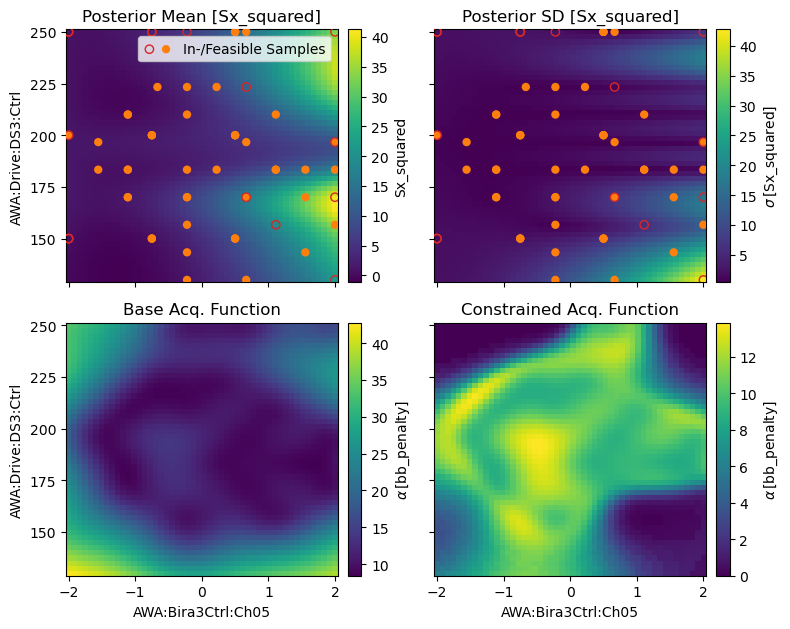

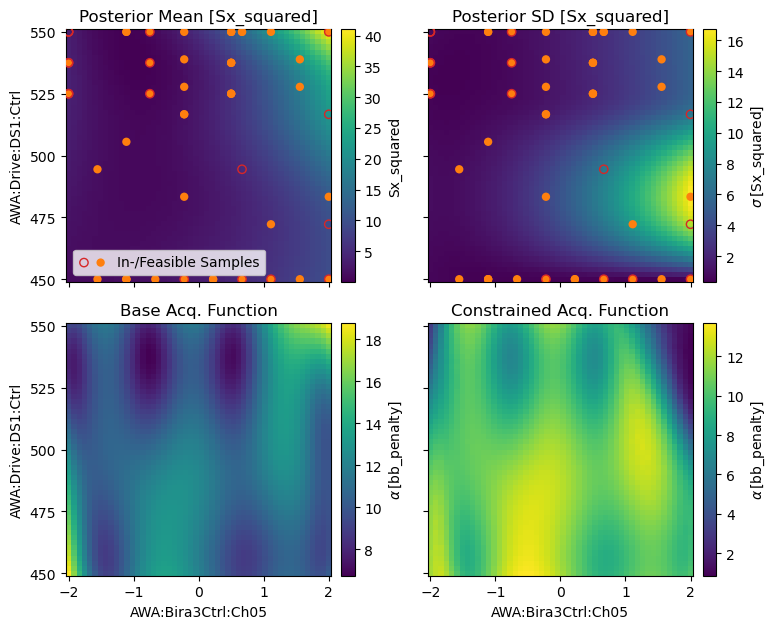

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DS3:Ctrl"],
    output_names=["Sx_squared"],
)

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DS1:Ctrl"],
    output_names=["Sx_squared"],
)

#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [16]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.super_low_noise import SuperLowNoiseModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bayesian_exploration import BayesianExplorationGenerator
from xopt.numerical_optimizer import GridOptimizer
from copy import deepcopy
sys.path.append("../../emitopt/")
import torch
from emitopt.algorithms import ScipyMinimizeEmittanceXY

meas_dim = 0
tuning_dims = [1,2]
covar_module = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'Sx_squared': scaled_covar_module, "Sy_squared": deepcopy(scaled_covar_module)}
# covar_module_dict = {}
model_constructor = SuperLowNoiseModelConstructor(
    covar_modules=covar_module_dict, use_low_noise_prior=True
)

from emitopt.utils import get_quad_scale_factor
q_len=0.1

pv_scale = (q_len*10 / 0.893) # [kG] / [A] for AWA Blue quads
geo_scale_factor = get_quad_scale_factor(E=0.060, q_len=q_len) # [m^-2] / [kG] 


scale_factor = pv_scale * geo_scale_factor
rmat_x = torch.tensor(((1.0,2.375),(0.0,1.0)))
rmat_y = torch.tensor(((1.0,2.375),(0.0,1.0)))
n_samples=10

algo_kwargs = {
        'x_key': 'Sx_squared',
        'y_key': 'Sy_squared',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': False,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    numerical_optimizer=GridOptimizer(n_grid_points=10)
    #n_interpolate_points=5,
)


from xopt import Xopt
X_bax = Xopt(vocs=vocs, generator=generator, 
         evaluator=evaluator, strict=True)#,dump_file="bax_emittance_3d_x_y_2.yml")
X_bax.add_data(X.data)


In [33]:
for i in range(10):
    X.step()

fitting image
174.66948659925066 155.0
fitting image
174.02596919733278 155.0
fitting image
158.7066702067717 155.0
fitting image
195.9312046209962 155.0
fitting image
181.75900847591075 155.0
fitting image
182.34327986999736 155.0
fitting image
199.05169502647362 155.0
fitting image
191.97576583249605 155.0
fitting image
196.05560322222692 155.0
fitting image
181.50181624279963 155.0


<Axes: >

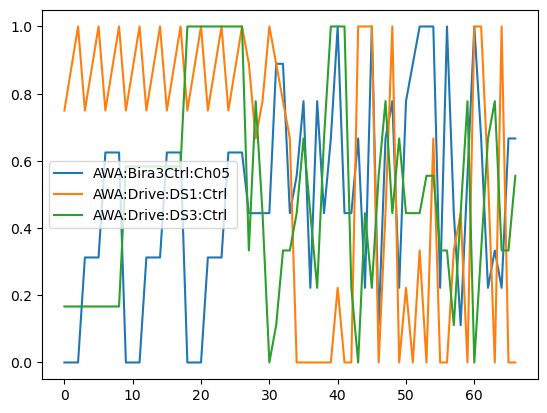

In [34]:
X.vocs.normalize_inputs(X_bax.data).plot(y=X.vocs.variable_names)

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


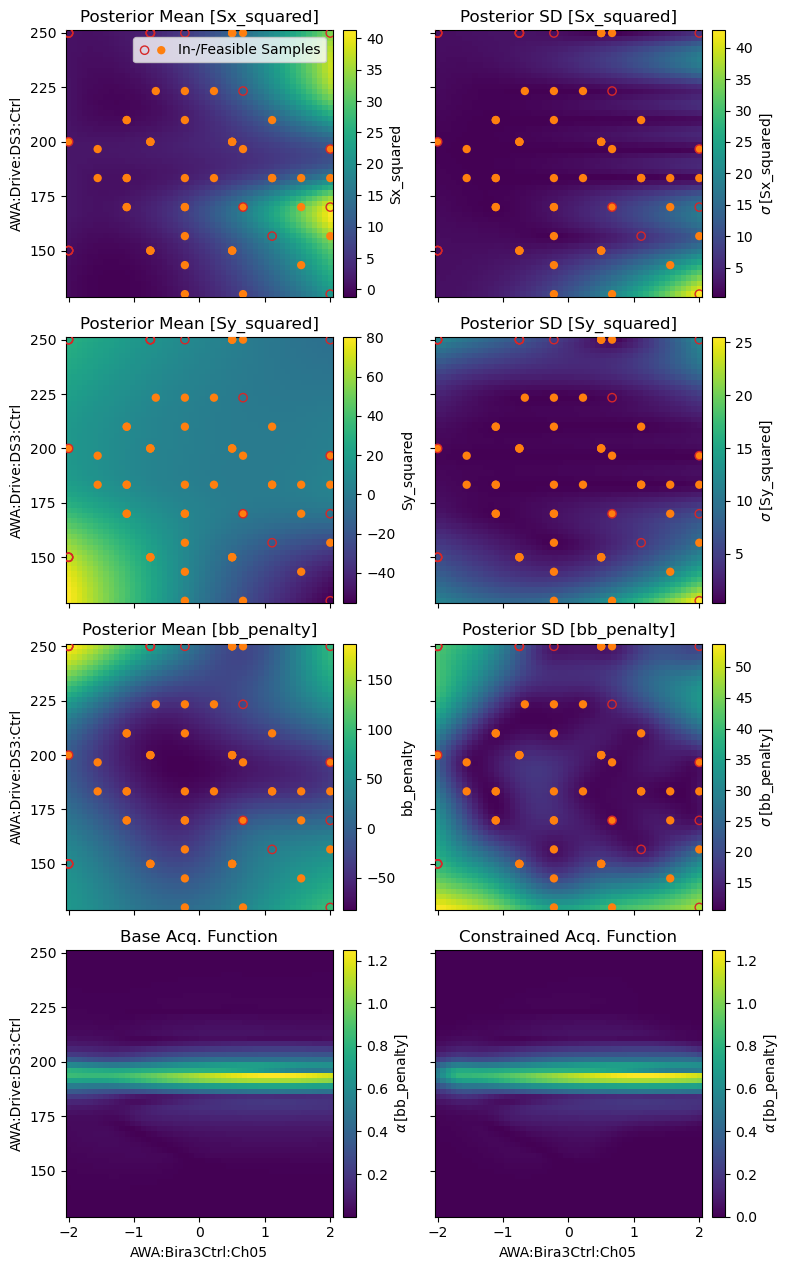

In [50]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X_bax.generator.train_model()
fig,ax = visualize_generator_model(
    X_bax.generator, 
    reference_point={"AWA:Drive:DS1:Ctrl":450.0},
    variable_names=["AWA:Bira3Ctrl:Ch05","AWA:Drive:DS3:Ctrl"],
    output_names=["Sx_squared","Sy_squared","bb_penalty"],
)

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 600x600 with 4 Axes>,
 array([[<Axes: xlabel='AWA:Drive:DS1:Ctrl', ylabel='Emittance'>,
         <Axes: xlabel='AWA:Drive:DS3:Ctrl'>],
        [<Axes: xlabel='AWA:Drive:DS1:Ctrl', ylabel='Sample Validity Rate'>,
         <Axes: xlabel='AWA:Drive:DS3:Ctrl'>]], dtype=object))

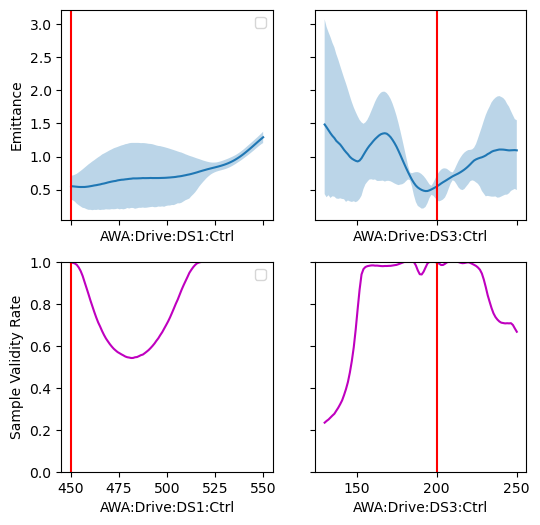

In [57]:
from emitopt.plot_utils import plot_virtual_emittance_vs_tuning, plot_pathwise_emittance_vs_tuning
plot_virtual_emittance_vs_tuning(X_bax, torch.tensor([[450.,200]]),n_points=50)

In [55]:
X_bax.generator.algorithm_results

{'xs_exe': tensor([[[-2.0000e+00,  4.5000e+02,  1.9382e+02],
          [-1.6000e+00,  4.5000e+02,  1.9382e+02],
          [-1.2000e+00,  4.5000e+02,  1.9382e+02],
          [-8.0000e-01,  4.5000e+02,  1.9382e+02],
          [-4.0000e-01,  4.5000e+02,  1.9382e+02],
          [-1.1102e-16,  4.5000e+02,  1.9382e+02],
          [ 4.0000e-01,  4.5000e+02,  1.9382e+02],
          [ 8.0000e-01,  4.5000e+02,  1.9382e+02],
          [ 1.2000e+00,  4.5000e+02,  1.9382e+02],
          [ 1.6000e+00,  4.5000e+02,  1.9382e+02],
          [ 2.0000e+00,  4.5000e+02,  1.9382e+02]],
 
         [[-2.0000e+00,  4.5000e+02,  1.9273e+02],
          [-1.6000e+00,  4.5000e+02,  1.9273e+02],
          [-1.2000e+00,  4.5000e+02,  1.9273e+02],
          [-8.0000e-01,  4.5000e+02,  1.9273e+02],
          [-4.0000e-01,  4.5000e+02,  1.9273e+02],
          [-1.1102e-16,  4.5000e+02,  1.9273e+02],
          [ 4.0000e-01,  4.5000e+02,  1.9273e+02],
          [ 8.0000e-01,  4.5000e+02,  1.9273e+02],
          [ 1.2000

/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


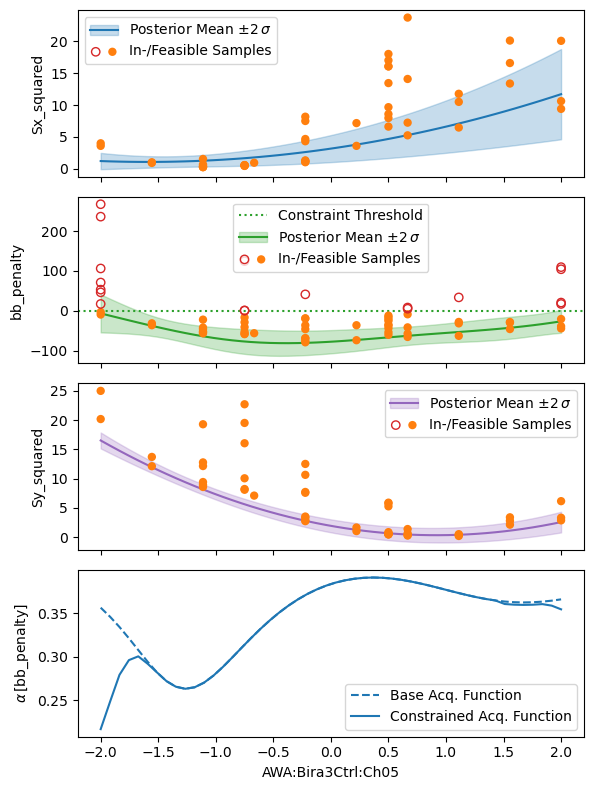

In [56]:
fig,ax = visualize_generator_model(
    X_bax.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch05"],
    output_names=["Sx_squared","bb_penalty","Sy_squared"],
    reference_point={"AWA:Drive:DS1:Ctrl":450.0,"AWA:Drive:DS3:Ctrl":200},
)

/tmp/ipykernel_1386091/971761469.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_bax.data[X_bax.data["AWA:Drive:DS1:Ctrl"]==550.0][X_bax.data["AWA:Drive:DS3:Ctrl"]==210.0].plot(


<Axes: xlabel='AWA:Bira3Ctrl:Ch05'>

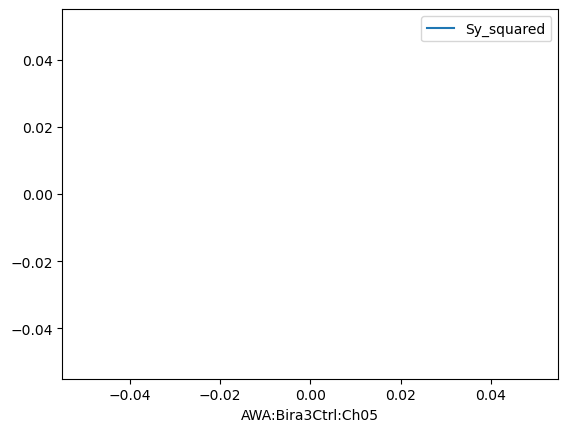

In [20]:
X_bax.data[X_bax.data["AWA:Drive:DS1:Ctrl"]==550.0][X_bax.data["AWA:Drive:DS3:Ctrl"]==210.0].plot(
    x="AWA:Bira3Ctrl:Ch05",y="Sy_squared"
)

In [40]:
X_bax.data["AWA:Drive:DS3:Ctrl"].unique()

array([150.        , 200.        , 250.        , 170.        ,
       223.33332825, 183.33334351, 130.00001526, 143.33334351,
       210.        , 156.66667175, 249.99998474, 196.66665649])

In [53]:
X_bax.dump_file = "grid_be_bax.yml"
X_bax.dump()

array([[<Axes: title={'center': 'AWA:Drive:DS3:Ctrl'}>]], dtype=object)

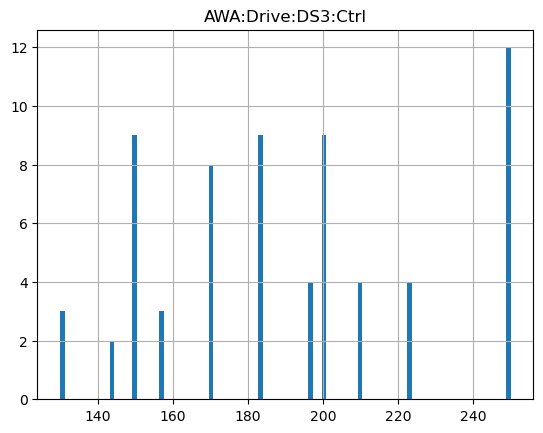

In [21]:
X.data.hist("AWA:Drive:DS3:Ctrl",bins=100)

In [22]:
X.data

,AWA:Bira3Ctrl:Ch05,AWA:Drive:DS3:Ctrl,AWA:Drive:DS1:Ctrl,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,...,Sx_m,Sx_squared,Sy_m,Sy_squared,center_dist_x,center_dist_y,center_dist,time,xopt_runtime,xopt_error
0,-2.000000,150.000000,525.000000,NaN,NaN,NaN,NaN,46.069777,6500991.0,6.812980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710789e+09,4.361468,False
1,-2.000000,150.000000,537.500000,NaN,NaN,NaN,NaN,70.815365,6555335.0,6.816595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710789e+09,4.242524,False
2,-2.000000,150.000000,550.000000,NaN,NaN,NaN,NaN,52.887166,6527625.0,6.814755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710789e+09,4.295862,False
3,-0.750000,150.000000,525.000000,190.192306,146.184621,6.153662,39.457295,-16.959151,6753797.0,6.829548,...,0.743347,0.552565,4.766345,22.718049,35.192306,-8.815379,36.279599,1.710789e+09,4.276304,False
4,-0.750000,150.000000,537.500000,191.187845,158.629201,6.268685,36.581029,-28.993635,6649609.0,6.822796,...,0.757242,0.573415,4.418899,19.526672,36.187845,3.629201,36.369372,1.710789e+09,4.331905,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,-1.111106,210.000000,505.555542,189.622064,169.931776,4.372328,24.762644,-53.811200,6425081.0,6.807879,...,0.528167,0.278960,2.991267,8.947680,34.622064,14.931776,37.704711,1.710789e+09,4.342579,False
63,-0.666663,223.333328,450.000000,193.168775,164.874628,8.094799,22.085727,-56.529440,6479547.0,6.811545,...,0.977832,0.956156,2.667902,7.117702,38.168775,9.874628,39.425419,1.710789e+09,4.242463,False
64,-1.111106,170.000000,550.000000,193.050380,163.994339,5.904473,29.602182,-42.418409,6532706.0,6.815093,...,0.713246,0.508720,3.575872,12.786859,38.050380,8.994339,39.098972,1.710789e+09,4.274916,False
65,0.666663,170.000000,450.000000,NaN,NaN,NaN,NaN,4.977227,6680339.0,6.824799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710789e+09,4.304037,False


In [23]:
from emitopt.plot_utils import plot_virtual_measurement_scan
plot_virtual_measurement_scan(X, torch.tensor([[220.]]))

AttributeError: 'BayesianExplorationGenerator' object has no attribute 'algorithm'

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model

fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":0.25},
    output_names=["Cx"]
)

fig2,ax2 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.0},
    output_names=["Cx"]
)

fig3,ax3 = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03"],
    reference_point={"AWA:Drive:DT8H_B_S:Ctrl":1.1},
    output_names=["Cx"]
)

In [ ]:
from xopt.generators.bayesian.visualize import visualize_generator_model
X.generator.train_model()
fig,ax = visualize_generator_model(
    X.generator, 
    variable_names=["AWA:Bira3Ctrl:Ch03","AWA:Drive:DT8H_B_S:Ctrl"],
    output_names=["Cx"]
)
#X_stars = X.generator.algorithm_results["X_stars"]
#for ele in X_stars:
#    ax[0,0].axhline(ele,c="C3", xmax=0.1)


In [ ]:
import yaml
with open("bax_scan_1.yml") as stream:
    d =yaml.safe_load(stream)
import pandas as pd
import torch
df =pd.DataFrame(d['data'])
df

df2 =df[df['AWA:Drive:DS3:Ctrl'] == 230.]
df2
df3 =df2.dropna()
df3

x = torch.tensor(df3['AWA:Bira3Ctrl:Ch03'])
y = torch.tensor(df3['Sx_squared'])

from emitopt.utils import get_quad_scale_factor
q_len = 0.1
pv_scale = (q_len*10 / 0.893) # [kG] / [A] for AWA Blue quads
geo_scale_factor = get_quad_scale_factor(E=0.060, q_len=q_len) # [m^-=2] / [kG]

scale_factor =pv_scale * geo_scale_factor
k =scale_factor * x
k

import matplotlib.pyplot as plt
plt.scatter(k, y)
plt.figure()

from emitopt.analysis import compute_emit_bmag, compute_emit_bayesian
rmat_x =torch.tensor(((1.0,2.375),(0.0,1.0)))
#emit = compute_emit_bmag(k, y, q_len, rmat_x)[0]
emit =compute_emit_bayesian(
    k, y.sqrt(), q_len, 
    rmat_x,visualize=True,noise_prior=GammaPrior(1.0, 10.0))[0]
plt.hist(emit)


In [ ]:
x_tuning =  torch.tensor([[220.]])
n_samples = 100

bax_model_ids = [
    X.generator.vocs.output_names.index(name)
    for name in X.generator.algorithm.observable_names_ordered
]
bax_model = X.generator.model.subset_output(bax_model_ids)

x = X.generator.algorithm.get_meas_scan_inputs(x_tuning, X.generator.vocs.bounds) # result shape n_tuning_configs*n_steps x ndim

p = bax_model.posterior(x)
bss = p.sample(torch.Size([n_samples])) # result shape n_samples x n_tuning_configs*n_steps x num_outputs (1 or 2)

x = x.reshape(x_tuning.shape[0], X.generator.algorithm.n_steps_measurement_param, -1) # result n_tuning_configs x n_steps x ndim
x = x.repeat(n_samples,1,1,1)
# result shape n_samples x n_tuning_configs x n_steps x ndim
bss = bss.reshape(n_samples, x_tuning.shape[0], X.generator.algorithm.n_steps_measurement_param, -1)
# result shape n_samples x n_tuning_configs x n_steps x num_outputs (1 or 2)

In [ ]:
import matplotlib.pyplot as plt
from emitopt.analysis import compute_emit_bmag, compute_emit_bayesian

for i in range(40):
    plt.plot(x[i,0,:,0],bss[i,0,:,0],'C0')
    emit = compute_emit_bmag(
        scale_factor *x[i,0,:,0],bss[i,0,:,0], q_len, rmat_x,thick=False
    )[0]
    print(emit)

plt.ylim(-0.75,14)
plt.xlim(-0.8,0.6)